In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage import binary_dilation, binary_erosion
import copy

import cc3d
import torch

from monai.metrics import compute_iou
import torch.nn.functional as F

from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric, SurfaceDistanceMetric

from scipy.ndimage import distance_transform_edt

#from panoptic_measure import panoptic_quality
from scipy.ndimage import label
from skimage.metrics import adapted_rand_error

import nibabel as nib

import gc
import os

import sys
import math

In [2]:
def dice(im1, im2):
    """
    Computes Dice score for two images

    Parameters
    ==========
    im1: Numpy Array/Matrix; Predicted segmentation in matrix form 
    im2: Numpy Array/Matrix; Ground truth segmentation in matrix form

    Output
    ======
    dice_score: Dice score between two images
    """

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * (intersection.sum()) / (im1.sum() + im2.sum())

def get_TissueWiseSeg(prediction_matrix, gt_matrix, tissue_type):
    """
    Converts the segmentatations to isolate tissue types

    Parameters
    ==========
    prediction_matrix: Numpy Array/Matrix; Predicted segmentation in matrix form 
    gt_matrix: Numpy Array/Matrix; Ground truth segmentation in matrix form
    tissue_type: str; Can be WT, ET or TC

    Output
    ======
    prediction_matrix: Numpy Array/Matrix; Predicted segmentation in matrix form with 
                       just tissue type mentioned
    gt_matrix: Numpy Array/Matrix; Ground truth segmentation in matrix form with just 
                       tissue type mentioned
    """

    if tissue_type == 'WT':
        np.place(prediction_matrix, (prediction_matrix != 1) & (prediction_matrix != 2) & (prediction_matrix != 3), 0)
        np.place(prediction_matrix, (prediction_matrix > 0), 1)
        
        np.place(gt_matrix, (gt_matrix != 1) & (gt_matrix != 2) & (gt_matrix != 3), 0)
        np.place(gt_matrix, (gt_matrix > 0), 1)
    
    elif tissue_type == 'TC':
        np.place(prediction_matrix, (prediction_matrix != 1)  & (prediction_matrix != 3), 0)
        np.place(prediction_matrix, (prediction_matrix > 0), 1)
        
        np.place(gt_matrix, (gt_matrix != 1) & (gt_matrix != 3), 0)
        np.place(gt_matrix, (gt_matrix > 0), 1)
        
    elif tissue_type == 'ET':
        np.place(prediction_matrix, (prediction_matrix != 3), 0)
        np.place(prediction_matrix, (prediction_matrix > 0), 1)
        
        np.place(gt_matrix, (gt_matrix != 3), 0)
        np.place(gt_matrix, (gt_matrix > 0), 1)
    
    return prediction_matrix, gt_matrix


def get_GTseg_combinedByDilation(gt_dilated_cc_mat, gt_label_cc):
    """
    Computes the Corrected Connected Components after combing lesions
    together with respect to their dilation extent

    Parameters
    ==========
    gt_dilated_cc_mat: Numpy Array/Matrix; Ground Truth Dilated Segmentation 
                       after CC Analysis
    gt_label_cc: Numpy Array/Matrix; Ground Truth Segmentation after 
                       CC Analysis

    Output
    ======
    gt_seg_combinedByDilation_mat: Numpy Array/Matrix; Ground Truth 
                                   Segmentation after CC Analysis and 
                                   combining lesions
    """    
    
    
    gt_seg_combinedByDilation_mat = np.zeros_like(gt_dilated_cc_mat)

    for comp in range(np.max(gt_dilated_cc_mat)):  
        comp += 1

        gt_d_tmp = np.zeros_like(gt_dilated_cc_mat)
        gt_d_tmp[gt_dilated_cc_mat == comp] = 1
        gt_d_tmp = (gt_label_cc*gt_d_tmp)

        np.place(gt_d_tmp, gt_d_tmp > 0, comp)
        gt_seg_combinedByDilation_mat += gt_d_tmp
        
    return gt_seg_combinedByDilation_mat


def get_LesionWiseScores(pred_mat, gt_mat, label_value="WT", dil_factor=0):
    """
    Computes the Lesion-wise scores for pair of prediction and ground truth
    segmentations

    Parameters
    ==========
    prediction_seg: str; location of the prediction segmentation    
    gt_label_cc: str; location of the gt segmentation
    label_value: str; Can be WT, ET or TC
    dil_factor: int; Used to perform dilation

    Output
    ======
    tp: Number of TP lesions WRT prediction segmentation
    fn: Number of FN lesions WRT prediction segmentation
    fp: Number of FP lesions WRT prediction segmentation 
    gt_tp: Number of Ground Truth TP lesions WRT prediction segmentation 
    metric_pairs: list; All the lesion-wise metrics  
    full_dice: Dice Score of the pair of segmentations
    full_gt_vol: Total Ground Truth Segmenatation Volume
    full_pred_vol: Total Prediction Segmentation Volume
    """

    ## Get Prediction and GT segs matrix files
    #pred_nii = nib.load(prediction_seg)
    #gt_nii = nib.load(gt_seg)
    #pred_mat = pred_nii.get_fdata()
    #gt_mat = gt_nii.get_fdata()

    ## Get Spacing to computes volumes
    ## Brats Assumes all spacing is 1x1x1mm3
    sx, sy, sz = 1,1,1

    ## Get the prediction and GT matrix based on 
    ## WT, TC, ET

    #pred_mat, gt_mat = get_TissueWiseSeg(
    #                            prediction_matrix = pred_mat,
    #                            gt_matrix = gt_mat,
    #                            tissue_type = label_value
    #                        )
    
    ## Get Dice score for the full image
    if np.all(gt_mat==0) and np.all(pred_mat==0):
        full_dice = 1.0
    else:
        full_dice = dice(
                    pred_mat, 
                    gt_mat
                )
    
    ## Get HD95 sccre for the full image
    
    #if np.all(gt_mat==0) and np.all(pred_mat==0):
    #    full_hd95 = 0.0
    #else:
    #    full_sd = surface_distance.compute_surface_distances(gt_mat.astype(int), 
    #                                                         pred_mat.astype(int), 
    #                                                         (sx,sy,sz))
    #    full_hd95 = surface_distance.compute_robust_hausdorff(full_sd, 95)

    ## Get Sensitivity and Specificity
    full_sens, full_specs = get_sensitivity_and_specificity(result_array = pred_mat, 
                                                            target_array = gt_mat)
    
    ## Get GT Volume and Pred Volume for the full image
    full_gt_vol = np.sum(gt_mat)*sx*sy*sz
    full_pred_vol = np.sum(pred_mat)*sx*sy*sz

    ## Performing Dilation and CC analysis

    dilation_struct = scipy.ndimage.generate_binary_structure(3, 2)

    gt_mat_cc = cc3d.connected_components(gt_mat, connectivity=26)
    pred_mat_cc = cc3d.connected_components(pred_mat, connectivity=26)

    if dil_factor > 0:
        gt_mat_dilation = scipy.ndimage.binary_dilation(gt_mat, structure = dilation_struct, iterations = dil_factor)
    else:
        gt_mat_dilation = gt_mat
    gt_mat_dilation_cc = cc3d.connected_components(gt_mat_dilation, connectivity=26)

    gt_mat_combinedByDilation = get_GTseg_combinedByDilation(
                                                            gt_dilated_cc_mat = gt_mat_dilation_cc, 
                                                            gt_label_cc = gt_mat_cc
                                                        )
    
    ## Performing the Lesion-By-Lesion Comparison

    gt_label_cc = gt_mat_combinedByDilation
    pred_label_cc = pred_mat_cc

    gt_tp = []
    tp = []
    fn = []
    fp = []
    metric_pairs = []

    for gtcomp in range(np.max(gt_label_cc)):
        gtcomp += 1

        ## Extracting current lesion
        gt_tmp = np.zeros_like(gt_label_cc)
        gt_tmp[gt_label_cc == gtcomp] = 1

        ## Extracting ROI GT lesion component
        if dil_factor>0:
            gt_tmp_dilation = scipy.ndimage.binary_dilation(gt_tmp, structure = dilation_struct, iterations = dil_factor)
        else: 
            gt_tmp_dilation = gt_tmp
        # Volume of lesion
        gt_vol = np.sum(gt_tmp)*sx*sy*sz 
        
        ## Extracting Predicted true positive lesions
        pred_tmp = np.copy(pred_label_cc)
        #pred_tmp = pred_tmp*gt_tmp
        pred_tmp = pred_tmp*gt_tmp_dilation
        intersecting_cc = np.unique(pred_tmp) 
        intersecting_cc = intersecting_cc[intersecting_cc != 0] 
        for cc in intersecting_cc:
            tp.append(cc)

        ## Isolating Predited Lesions to calulcate Metrics
        pred_tmp = np.copy(pred_label_cc)
        pred_tmp[np.isin(pred_tmp,intersecting_cc,invert=True)] = 0
        pred_tmp[np.isin(pred_tmp,intersecting_cc)] = 1

        ## Calculating Lesion-wise Dice and HD95
        dice_score = dice(pred_tmp, gt_tmp)
        #surface_distances = surface_distance.compute_surface_distances(gt_tmp, pred_tmp, (sx,sy,sz))
        #hd = surface_distance.compute_robust_hausdorff(surface_distances, 95)

        metric_pairs.append((intersecting_cc, 
                            gtcomp, gt_vol, dice_score, 
                             #hd
                            ))
        
        ## Extracting Number of TP/FP/FN and other data
        if len(intersecting_cc) > 0:
            gt_tp.append(gtcomp)
        else:
            fn.append(gtcomp)

    fp = np.unique(
            pred_label_cc[np.isin(
                pred_label_cc,tp+[0],invert=True)])
    
    #return tp, fn, fp, gt_tp, metric_pairs, full_dice, full_hd95, full_gt_vol, full_pred_vol, full_sens, full_specs
    return tp, fn, fp, gt_tp, metric_pairs, full_dice, full_gt_vol, full_pred_vol, full_sens, full_specs


def get_sensitivity_and_specificity(result_array, target_array):
    """
    This function is extracted from GaNDLF from mlcommons

    You can find the documentation here - 

    https://github.com/mlcommons/GaNDLF/blob/master/GANDLF/metrics/segmentation.py#L196

    """
    iC = np.sum(result_array)
    rC = np.sum(target_array)

    overlap = np.where((result_array == target_array), 1, 0)

    # Where they agree are both equal to that value
    TP = overlap[result_array == 1].sum()
    FP = iC - TP
    FN = rC - TP
    TN = np.count_nonzero((result_array != 1) & (target_array != 1))

    Sens = 1.0 * TP / (TP + FN + sys.float_info.min)
    Spec = 1.0 * TN / (TN + FP + sys.float_info.min)

    # Make Changes if both input and reference are 0 for the tissue type
    if (iC == 0) and (rC == 0):
        Sens = 1.0

    return Sens, Spec



def get_LesionWiseResults(pred_file, gt_file, challenge_name='BraTS-GLI', output=None):
    """
    Computes the Lesion-wise scores for pair of prediction and ground truth
    segmentations

    Parameters
    ==========
    pred_file: str; location of the prediction segmentation    
    gt_file: str; location of the gt segmentation
    challenge_name: str; name of the challenge for parameters


    Output
    ======
    Saves the performance metrics as CSVs
    results_df: pd.DataFrame; lesion-wise results with other metrics
    """
    
    if challenge_name == 'BraTS-GLI':
        dilation_factor = 0
        lesion_volume_thresh = 0  
    else:
        raise ValueError
        

    final_lesionwise_metrics_df = pd.DataFrame()
    final_metrics_dict = dict()
    label_values = ['WT', 'TC', 'ET']

    for l in range(len(label_values)):
        tp, fn, fp, gt_tp, metric_pairs, full_dice, full_hd95, full_gt_vol, full_pred_vol, full_sens, full_specs = get_LesionWiseScores(
                                                            prediction_seg = pred_file,
                                                            gt_seg = gt_file,
                                                            label_value = label_values[l],
                                                            dil_factor = dilation_factor
                                                        )
        
        metric_df = pd.DataFrame(
            metric_pairs, columns=['predicted_lesion_numbers', 'gt_lesion_numbers', 
                                   'gt_lesion_vol', 'dice_lesionwise', 'hd95_lesionwise']
                ).sort_values(by = ['gt_lesion_numbers'], ascending=True).reset_index(drop = True)
        
        metric_df['_len'] = metric_df['predicted_lesion_numbers'].map(len)

        ## Removing <= 50 lesions from analysis
        fn_sub = (metric_df[(metric_df['_len'] == 0) &
                  (metric_df['gt_lesion_vol'] <= lesion_volume_thresh)
                  ]).shape[0]
        
        
        gt_tp_sub = (metric_df[(metric_df['_len'] != 0) & 
            (metric_df['gt_lesion_vol'] <= lesion_volume_thresh)
            ]).shape[0]
        
        
        metric_df['Label'] = [label_values[l]]*len(metric_df)
        metric_df = metric_df.replace(np.inf, 374)

        final_lesionwise_metrics_df = final_lesionwise_metrics_df.append(metric_df)
        metric_df_thresh = metric_df[metric_df['gt_lesion_vol'] > lesion_volume_thresh]
        
        try:
            lesion_wise_dice = np.sum(metric_df_thresh['dice_lesionwise'])/(len(metric_df_thresh) + len(fp))
        except:
            lesion_wise_dice = np.nan
            
        try:
            lesion_wise_hd95 = (np.sum(metric_df_thresh['hd95_lesionwise']) + len(fp)*374)/(len(metric_df_thresh) + len(fp))
        except:
            lesion_wise_hd95 = np.nan

        if math.isnan(lesion_wise_dice):
            lesion_wise_dice = 1

        if math.isnan(lesion_wise_hd95):
            lesion_wise_hd95 = 0
        
        metrics_dict = {
            'Num_TP' : len(gt_tp) - gt_tp_sub, # GT_TP
            #'Num_TP' : len(tp),
            'Num_FP' : len(fp),
            'Num_FN' : len(fn) - fn_sub,
            'Sensitivity': full_sens,
            'Specificity': full_specs,
            'Legacy_Dice' : full_dice,
            'Legacy_HD95' : full_hd95,
            'GT_Complete_Volume' : full_gt_vol,
            'LesionWise_Score_Dice' : lesion_wise_dice,
            'LesionWise_Score_HD95' : lesion_wise_hd95
        }

        final_metrics_dict[label_values[l]] = metrics_dict


    #final_lesionwise_metrics_df.to_csv(os.path.split(pred_file)[0] + '/' +
    #                                   os.path.split(pred_file)[1].split('.')[0] + 
    #                                   '_lesionwise_metrics.csv',
    #                                   index=False)
    
    
    results_df = pd.DataFrame(final_metrics_dict).T
    results_df['Labels'] = results_df.index
    results_df = results_df.reset_index(drop=True)
    results_df.insert(0, 'Labels', results_df.pop('Labels'))
    results_df.replace(np.inf, 374, inplace=True)
    
    if output:
        results_df.to_csv(output, index=False)
    
    return results_df


In [3]:
def calculate_iou(gt, pred):
    intersection = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    if union == 0:
        return 0
    return intersection / union

def panoptic_quality(pred_inp, gt_inp):
    threshold = 0.5  # Set IoU threshold to 0.5 as per the paper
    # Label connected components, ignore background!
    
    pred = pred_inp.argmax(dim=1).squeeze()
    gt = gt_inp.argmax(dim=1).squeeze()
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    gt_labeled, gt_num = label(gt > 0)
    pred_labeled, pred_num = label(pred > 0)
    
    #gt_labeled, gt_num = label(gt)
    #pred_labeled, pred_num = label(pred)
    
    # Track matching components and their IoU
    matches = []
    for gt_id in range(1, gt_num + 1):
        gt_component = (gt_labeled == gt_id)
        for pred_id in range(1, pred_num + 1):
            pred_component = (pred_labeled == pred_id)
            iou = calculate_iou(gt_component, pred_component)
            if iou > threshold:
                matches.append((iou, gt_id, pred_id))
    
    # Sort matches by IoU in descending order
    matches.sort(reverse=True, key=lambda x: x[0])
    
    # Track used components
    used_gt = set()
    used_pred = set()
    
    tp = 0  # True Positives
    sum_iou = 0
    
    for iou, gt_id, pred_id in matches:
        if gt_id not in used_gt and pred_id not in used_pred:
            tp += 1
            sum_iou += iou
            used_gt.add(gt_id)
            used_pred.add(pred_id)
    
    fp = pred_num - tp  # False Positives
    fn = gt_num - tp    # False Negatives
    
    # Calculate PQ
    if tp + fp + fn == 0:
        pq = 1.0
    else:
        pq = sum_iou / (tp + 0.5 * fp + 0.5 * fn)
    
    return torch.as_tensor(pq) 

In [4]:
def compute_all_metrics(cc_labels, array, s, drop_cc=False, caching_dir=".",caching_name="toy.npy"):
    cc_dt = []

    if not drop_cc and os.path.exists(os.path.join(caching_dir,caching_name)):
        cc_asignment = np.load(os.path.join(caching_dir,caching_name))
    else:
        for cc in np.unique(cc_labels):
            if cc == 0:
                pass
            else:
                cc_dt.append(
                    distance_transform_edt(np.logical_not(cc_labels == cc)).astype(np.float32) 
                    #Convert to float 32 due to 64GB Ram limitation
                    )
        cc_asignment = np.argmin(np.stack(cc_dt),axis=0)+1
    if drop_cc:
        np.save(os.path.join(caching_dir,caching_name),cc_asignment)    
    original_labels = torch.from_numpy(array)
    cc_asignment = torch.from_numpy(cc_asignment)


    scenario_predictions = torch.from_numpy(s)
    
    cur_pred = F.one_hot(scenario_predictions.unsqueeze(0).long(),num_classes=2)
    cur_pred = cur_pred.permute(0,4,1,2,3)
    cur_labels = F.one_hot(original_labels.unsqueeze(0).long(),num_classes=2)
    cur_labels = cur_labels.permute(0,4,1,2,3)
    cur_cc_asignment = cc_asignment.unsqueeze(0)
    
    metrics = {
        "DiceMetric": DiceMetric(include_background=False, reduction="mean"),
        #"HausdorffDistance": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=None, directed=False, reduction='mean', get_not_nans=False),
        #"HausdorffDistance95": HausdorffDistanceMetric(include_background=False, distance_metric='euclidean',percentile=95, directed=False, reduction='mean', get_not_nans=False),
        #"SurfaceDistance": SurfaceDistanceMetric(include_background=False, symmetric=False, distance_metric='euclidean', reduction='mean', get_not_nans=False),
        #"SurfaceDiceMetric": SurfaceDiceMetric(class_thresholds=[1] ,include_background=False, distance_metric='euclidean', reduction='mean', get_not_nans=False, use_subvoxels=False),
        #"PanopticQuality": panoptic_quality
    }
    
    this_patients_predictions = {
        #"PatientID": "/".join(label_path.split("/")[-3:-1]),
        #"n":n,
        #"k":k,
        #"p":p,
        "nof_ccs": len(np.unique(cc_labels)),
        #"cc_indices": unique_labels.tolist(),
        #"cc_voxel_count": cc_voxel_counts.tolist(),
        #"affected_cc_regions": affected_regions_idx
    }
    
    
    #Aggregate predictions
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            pass
        else: 
            metric(y_pred=cur_pred, y=cur_labels)
    
    #Reduce predictions for this patient
    for metric_name, metric in metrics.items():
        if metric_name == "PanopticQuality":
            global_metric_result = metric(cur_pred, cur_labels).item()
        else:
            global_metric_result = metric.aggregate().item()
        this_patients_predictions.update(
            {f"Global_{metric_name}":global_metric_result}
        )
        print(f"Global_{metric_name} -> {global_metric_result}")
        if metric_name !="PanopticQuality": metric.reset()
    
       
    
    cc_submetrics = {}
    
    #Report how many of the cc_regiond do not have any components
    missed_cc = 0
    
    for metric_name, metric in metrics.items():
        if metric_name !="PanopticQuality": metric.reset()
        
    for cc_id in cc_asignment.unique():
        
        pred_helper = copy.deepcopy(cur_pred).argmax(dim=1)
        label_helper = copy.deepcopy(cur_labels).argmax(dim=1)
        cc_mask = cur_cc_asignment == cc_id
        # Set the rest of gt and labels to background, to ignore during 
        pred_helper[
            torch.logical_not(cc_mask)
            ] = 0
        label_helper[
            torch.logical_not(cc_mask)
            ] = 0
        
    
        if pred_helper.sum() == 0:
            missed_cc += 1
        
        pred_helper = F.one_hot(pred_helper.long(),num_classes=2)
        pred_helper = pred_helper.permute(0,4,1,2,3)
        label_helper = F.one_hot(label_helper.long(),num_classes=2)
        label_helper = label_helper.permute(0,4,1,2,3)
    
        #Put into the the submetrics
        for metric_name, metric in metrics.items():
            
            
            if metric_name != "PanopticQuality":
                metric(y_pred=pred_helper, y=label_helper)
                submetric = metric.aggregate()
            else:
                submetric = metric(pred_helper, label_helper)
            
            if metric_name not in cc_submetrics:
                cc_submetrics.update({metric_name:[submetric.item()]})
            else:
                cc_submetrics[metric_name].append(submetric.item())
            
            if metric_name != "PanopticQuality": metric.reset()
    
            gc.collect()
    
    for metric_name, vals in cc_submetrics.items():
        aggregated_submetric = sum(vals)/len(vals)
        this_patients_predictions.update(
            {
                f"Submetric_{metric_name}_agg":aggregated_submetric,
                f"Submetric_{metric_name}_details":vals,
            }
        )
        print(f"Submetric_{metric_name} -> {aggregated_submetric}")
    this_patients_predictions.update(
        {f"Missed_cc_regions": missed_cc}
        )
    return this_patients_predictions

In [5]:
def compute_brats_dice(array,s,ret_details = False):
    tp, fn, fp, gt_tp, metric_pairs, full_dice,  full_gt_vol, full_pred_vol, full_sens, full_specs = get_LesionWiseScores(s,array)
    metric_df = pd.DataFrame(
                metric_pairs, columns=['predicted_lesion_numbers', 'gt_lesion_numbers', 
                                       'gt_lesion_vol', 'dice_lesionwise']
                    ).sort_values(by = ['gt_lesion_numbers'], ascending=True).reset_index(drop = True)
    metric_df['_len'] = metric_df['predicted_lesion_numbers'].map(len)
    ## Removing <= 50 lesions from analysis
    fn_sub = (metric_df[(metric_df['_len'] == 0) &
              (metric_df['gt_lesion_vol'] <= 0)
              ]).shape[0]
    gt_tp_sub = (metric_df[(metric_df['_len'] != 0) & 
        (metric_df['gt_lesion_vol'] <= 0)
        ]).shape[0]
    metric_df_thresh = metric_df[metric_df['gt_lesion_vol'] > 0]
    if not ret_details:
        return np.sum(metric_df_thresh['dice_lesionwise'])/(len(metric_df_thresh) + len(fp))
    else:
        return np.sum(metric_df_thresh['dice_lesionwise'])/(len(metric_df_thresh) + len(fp)), metric_pairs

In [6]:
size = 250
array = np.zeros((size, size, size), dtype=np.uint8)
# Define radii of the spheres
radius1 = 30
radius2 = 30
radius3 = 30
# Define centers of the spheres ensuring the distance constraints
center1 = np.array([75, 75, 75])
center2 = center1 + np.array([radius1 + radius2 + 10, 0, 0])  # 10 pixels apart
center3 = center1 + np.array([0, radius1 + radius3 + 25, 0])  # 25 pixels apart from both
# Function to draw a sphere in the 3D array
def draw_sphere(array, center, radius):
    for x in range(center[0] - radius, center[0] + radius):
        for y in range(center[1] - radius, center[1] + radius):
            for z in range(center[2] - radius, center[2] + radius):
                if (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 < radius**2:
                    array[x, y, z] = 1
# Draw the spheres
draw_sphere(array, center1, radius1)
draw_sphere(array, center2, radius2)
draw_sphere(array, center3, radius3)

In [7]:
#array = nib.load("array.nii.gz").get_fdata()
s = copy.deepcopy(array)
cc_labels = cc3d.connected_components(array)
structuring_element = np.ones((3,3,3), dtype=np.bool_)
results = []

brats_dice = compute_brats_dice(array,s)
cc_dice = compute_all_metrics(cc_labels, array,s,drop_cc=True,caching_name="same_size_balls.npy")

results.append({'brats':brats_dice, 'cc':cc_dice})
s = binary_dilation(s,structure=structuring_element, iterations=2)

for i in range(20):
    brats_dice = compute_brats_dice(array,s)
    cc_dice = compute_all_metrics(cc_labels, array,s,caching_name="same_size_balls.npy")
    results.append({'brats':brats_dice, 'cc':cc_dice})
    s = binary_dilation(s,structure=structuring_element, iterations=1)

Global_DiceMetric -> 1.0
Submetric_DiceMetric -> 1.0
Global_DiceMetric -> 0.860538125038147
Submetric_DiceMetric -> 0.860538125038147
Global_DiceMetric -> 0.7980651259422302
Submetric_DiceMetric -> 0.7980651259422302
Global_DiceMetric -> 0.7402447462081909
Submetric_DiceMetric -> 0.7402447462081909
Global_DiceMetric -> 0.6868613958358765
Submetric_DiceMetric -> 0.6868613958358765
Global_DiceMetric -> 0.6380780935287476
Submetric_DiceMetric -> 0.6380786498387655
Global_DiceMetric -> 0.5938085317611694
Submetric_DiceMetric -> 0.5938111146291097
Global_DiceMetric -> 0.553479790687561
Submetric_DiceMetric -> 0.5534881154696146
Global_DiceMetric -> 0.5166634321212769
Submetric_DiceMetric -> 0.5166825652122498
Global_DiceMetric -> 0.48299330472946167
Submetric_DiceMetric -> 0.48302991191546124
Global_DiceMetric -> 0.45216381549835205
Submetric_DiceMetric -> 0.4522250195344289
Global_DiceMetric -> 0.423903226852417
Submetric_DiceMetric -> 0.4239971935749054
Global_DiceMetric -> 0.397963613271

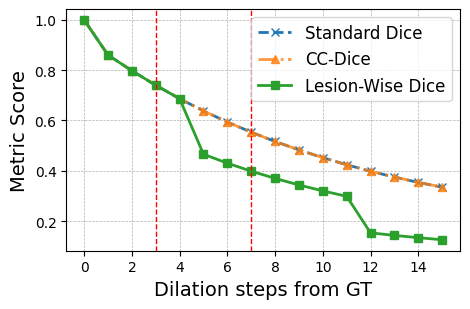

In [8]:
show_n = 16

plt.figure(figsize=(4.8, 3.2))
#plt.plot([x["cc"]["Submetric_DiceMetric_agg"] for x in results][:show_n], label="CC-Dice", linewidth=2, marker='s',alpha=0.8,linestyle='-.',)
plt.plot([x["cc"]["Global_DiceMetric"] for x in results][:show_n], label="Standard Dice", linewidth=2, marker='x',linestyle='--',)
plt.plot([x["cc"]["Submetric_DiceMetric_agg"] for x in results][:show_n], label="CC-Dice", linewidth=2, marker='^',alpha=0.8,linestyle='-.',)
plt.plot([x["brats"] for x in results][:show_n], label="Lesion-Wise Dice", linewidth=2, marker='s')



# Add gridlines
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Add legend with better placement
plt.legend(loc="best", fontsize=12, frameon=True)

# Set axis labels with larger fonts
plt.ylabel("Metric Score", fontsize=14)
plt.xlabel("Dilation steps from GT", fontsize=14)

# Set x-ticks
#plt.xticks(ticks=range(0, len(results[:show_n]),5), labels=range(0, len(results[:show_n])), fontsize=10)

# Improve the format of y-axis tick labels
#plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Set the plot's title
#plt.title("Comparison of Panoptic Quality, Dice and CC-Dice", fontsize=14)

highlight_steps = [3, 7]
for step in highlight_steps:
    plt.axvline(x=step, color='red', linestyle='--', linewidth=1)

# Save the plot as a high-resolution image
plt.tight_layout()
#plt.savefig("Brats_Dice_vs_CC_Dice_small_compact.pdf")